In [667]:
# load and filter data

import sys
import time
tic = time.time() 
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git\\TP4_ECAL-\\utils')
sys.path.insert(1, 'C:\\Users\\Pascal\\Desktop\\TP4a\\git_final_final\\ecal_reco\\tracking')
from data_loading import *
from tqdm import tqdm
from hit import Hit
from track3D import Track3D
from matplotlib import pyplot as plt
from track_reconstruction import *

file_path = 'C:\\Users\\Pascal\\Desktop\\TP4a\\data\\run_000002\\data_0000.root' 
import pandas as pd
import uproot
import numpy as np


N_cons_events = 1000 # number of events to consider

br_list_data = ['n_hits', 'tofpet_id', 'tofpet_channel', 'timestamp', 't_coarse', 't_fine', 'timestamp', 'v_coarse', 'v_fine', 'value']
br_list_evt = ['timestamp', 'evt_number', 'evt_flags']
evt_tree = 'event_data;1'
hits_tree = 'event_data;1'

with uproot.open(file_path) as tree:
    hits_dict = tree[hits_tree].arrays(br_list_data, library="np")
    evts_dict = tree[evt_tree].arrays(br_list_evt, library="np")
    
df_evts = pd.DataFrame.from_dict(evts_dict)
df_hits = pd.DataFrame.from_dict(hits_dict)
df_hits['timestamp_event'] = df_evts['timestamp']
df_hits = df_hits[0:N_cons_events]

og_len = len(df_hits)
df_hits.query('n_hits > 6', inplace=True)
df_hits.query('n_hits < 50', inplace=True)
new_len = len(df_hits)
print('selected {:.2f}% of all events'.format(new_len/og_len * 100))



selected 49.60% of all events


In [696]:
# functions def
def dist_from_curve(theta, sgamma, cgamma, x0, x1, isx):
    if(isx):
        return np.abs(-theta*sgamma*(x1[1]-x0[2])+x0[0]-x1[0])
    else:
        return np.abs(-theta*cgamma*(x1[1]-x0[2])+x0[1]-x1[0])
    
def error_fit(theta,sgamma,cgamma,x0,hits):
    error = 0
    for i in range(len(hits)):
        error += dist_from_curve(theta,sgamma,cgamma,x0,hits[i].get_pos(),hits[i].is_sidex)
    return error

def error_matrix(Hits,theta_vec,sgamma_vec,cgamma_vec,x0,y0,z0):
    Matrix = np.ndarray(shape=(len(theta_vec),len(cgamma_vec),len(x0),len(y0)), dtype=float)
    for i in range(len(theta_vec)):
        for j in range(len(cgamma_vec)):
            for k in range(len(x0)):
                for l in range(len(y0)):
                    Matrix[i][j][k][l] = error_fit(theta_vec[i],sgamma_vec[j],cgamma_vec[j],[x0[k],y0[l],z0],Hits)
    return Matrix

def find_3Dcurve(Hits, Nbr_It = 2, D = 5):
     # Finds the highest cell of index idmax
    Max = 0
     # number of time the iteration is ran
    for i in range(len(Hits)):
        if(Hits[i].get_pos()[1]>Max):
            idmax = i
            Max = Hits[i].get_pos()[1]

    X0 = Hits[idmax]
    z0 = X0.get_pos()[1]
    # generate the grid
    if D==2:
        gamma = np.linspace(0,2*np.pi,5)
        theta = np.linspace(0.01,80*np.pi*0.5/90,3)
    else:
        gamma = np.linspace(0,2*np.pi,D)
        theta = np.linspace(0.01,0.9*np.pi*0.5,D)
    ttheta = np.tan(theta)
    sgamma = np.sin(gamma)
    cgamma = np.cos(gamma)
    if(X0.is_sidex):
        x0 = np.linspace(X0.get_pos()[0]-0.8,X0.get_pos()[0]+0.8,D)
        y0 = np.linspace(0,38.4,D*24)
    else:
        y0 = np.linspace(X0.get_pos()[0]-0.8,X0.get_pos()[0]+0.8,D)
        x0 = np.linspace(0,38.4,D*24)
    
    # first approx in the whole bar
    
    M = error_matrix(Hits,ttheta,sgamma,cgamma,x0,y0,z0)
    
    idx=np.unravel_index(np.argmin(M, axis=None), M.shape)

    # iteration

    dt = np.abs(theta[1]-theta[0])
    dg = np.abs(gamma[1]-gamma[0])
    dx = x0[1]-x0[0]

    for i in range(Nbr_It):
        dt = 1.5*dt/D
        dg = 1.5*dg/D
        dx = 1.5*dx/D
        #new grid
        thetaold=theta[idx[0]]
        if thetaold-dt < 0.01:
            theta = np.linspace(0.01,thetaold+dt,D)
        elif thetaold+dt > 0.9*np.pi*0.5:
            theta = np.linspace(thetaold-dt,0.9*np.pi*0.5,D)
        else:
            theta = np.linspace(thetaold-dt,thetaold+dt,D)
        gammaold = gamma[idx[1]]
        gamma = np.mod(np.linspace(gammaold-dg,gammaold+dg,D),np.pi*2)

        ttheta = np.tan(theta)
        sgamma = np.sin(gamma)
        cgamma = np.cos(gamma)
        x0    = np.linspace(x0[idx[2]]-dx,x0[idx[2]]+dx,D)
        y0    = np.linspace(y0[idx[3]]-dx,y0[idx[3]]+dx,D)

        M = error_matrix(Hits,ttheta,sgamma,cgamma,x0,y0,z0)
        idx=np.unravel_index(np.argmin(M, axis=None), M.shape)
        
        
    return [theta[idx[0]], gamma[idx[1]],x0[idx[2]],y0[idx[3]],z0,M[idx]/len(Hits)] # pos 5 is <x^2>

In [697]:
# compute 3d tracks
minerror = [0, 1000]
i = 0
Result_Theta = []
Result_Gamma = []
Result_X0 = []
Result_Y0 = []
Result_Z0 = []
HitID = []
j = 0
t = time.time()
for index, row in tqdm(df_hits.iterrows(), total = df_hits.shape[0]):
    hits = [Hit(row,i) for i in range(row['n_hits'])]
    RETURN = find_3Dcurve(hits,10,2)
    if(np.sqrt(RETURN[5])<0.8):
        Result_Theta.append(RETURN[0]*360/(2*np.pi))
        Result_Gamma.append(RETURN[1]*360/(2*np.pi))
        Result_X0.append(RETURN[2])
        Result_Y0.append(RETURN[3])
        Result_Z0.append(RETURN[4])
        HitID.append(j)
        if(minerror[1]>RETURN[5]):
            minerror[1]=RETURN[5]
            minerror[0] = j
    j=j+1

print("Mean time per track : ", (time.time()-t)/len(df_hits))

  0%|          | 0/496 [00:00<?, ?it/s]

100%|██████████| 496/496 [00:55<00:00,  8.87it/s]

Mean time per track :  0.11269997348708491


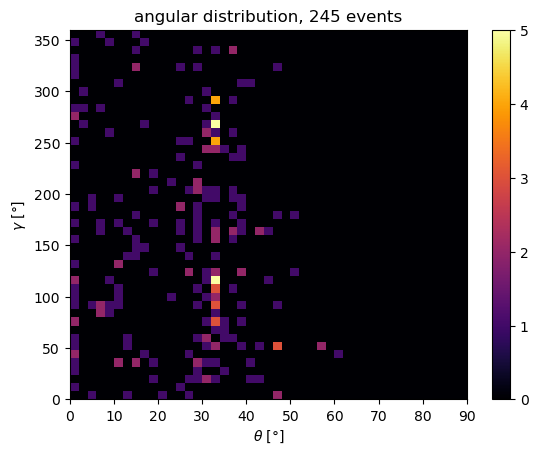

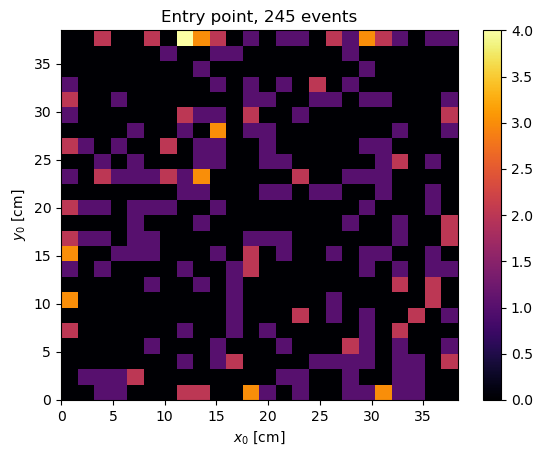

In [698]:
# plot angular distrib. and entry point distrib.
plt.figure()
plt.title('angular distribution, {} events'.format(len(Result_Theta)))
plt.hist2d(Result_Theta, Result_Gamma, bins =45, range = [[0, 90], [0, 360]], cmap = 'inferno')
plt.xlabel(r"$\theta$ [°]")
plt.ylabel(r"$\gamma$ [°]")
plt.colorbar()

plt.figure()
plt.title('Entry point, {} events'.format(len(Result_X0)))
plt.hist2d(Result_X0, Result_Y0, bins = 24, range = [[min(Result_X0), max(Result_X0)], [min(Result_Y0), max(Result_Y0)]], cmap = 'inferno')
plt.xlabel(r"$x_0$ [cm]")
plt.ylabel(r"$y_0$ [cm]")
plt.colorbar()

  0%|          | 0/496 [00:00<?, ?it/s]

100%|██████████| 496/496 [00:00<00:00, 9116.65it/s]


[16.127073377244013, 10.457609136053856, 15.200000000000001]


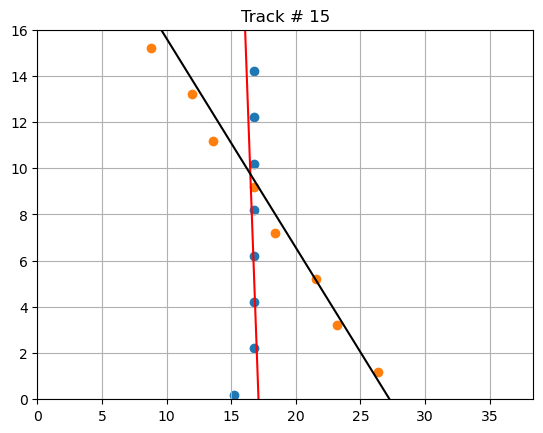

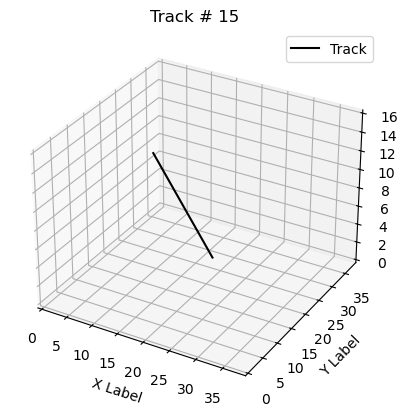

In [723]:
# plot all sort of stuff

from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D

ID = np.random.randint(0, len(Result_Gamma))

X0 = [Result_X0[ID],Result_Y0[ID],Result_Z0[ID]]
theta = Result_Theta[ID]*2*np.pi/360
gamma = Result_Gamma[ID]*2*np.pi/360
j = 0
for index, row in tqdm(df_hits.iterrows(), total = df_hits.shape[0]):
    if j == HitID[ID]:    
        hits = [Hit(row,i) for i in range(row['n_hits'])]
    j = j+1
a = [np.sin(gamma)*np.sin(theta),np.cos(gamma)*np.sin(theta),-np.cos(theta)]
tt = np.linspace((16-X0[2])/a[2],-X0[2]/a[2],1000)

xx = X0[0]+a[0]*tt
yy = X0[1]+a[1]*tt
zz = X0[2]+a[2]*tt

fig = plt.figure()
ax = plt.axes()
# ax = plt.axes(projection='3d')
ax.set_xlim(0,38.4)
ax.set_ylim(0,16)
ax.grid()
# ax.set_zlim(0,20)
plt.plot(xx,zz,'r-')

# ax.set_zlim(0,20)
plt.plot(yy,zz,'k-')

posx=[]
posy=[]
posyz=[]
posxz=[]

for i in range(len(hits)):
    if(hits[i].is_sidex):
        posx.append(hits[i].get_pos()[0])
        posxz.append(hits[i].get_pos()[1])
    else:
        posy.append(hits[i].get_pos()[0])
        posyz.append(hits[i].get_pos()[1])
plt.scatter(posx,posxz)
plt.scatter(posy,posyz)
ax.set_title('Track # {}'.format(i))
print(X0)
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create some sample data for the line

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the line in 3D
ax.plot(xx, yy, zz, 'k',label='Track')
ax.set_title('Track # {}'.format(i))

# Set labels for the axes
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
# Set custom axis limits
ax.axis('equal')
ax.set_xlim(0, 38.4)  # Set limits for the X axis
ax.set_ylim(0, 38.4)  # Set limits for the Y axis
ax.set_zlim(0, 16)  # Set limits for the Z axis
# Add a legend
ax.legend()

# Show the plot
plt.show()





In [640]:
t = time.time()
x0 = [0,0,0]
x1 = [0,0]
T = 20000
for i in range(T):
    error_fit(0,0,0,x0,hits)
print((time.time()-t)/T)
t = time.time()
for i in range(T):
    dist_from_curve(0,0,0,x0,x1,True)
print(17*(time.time()-t)/T)
t = time.time()
for i in range(T):
    dist_from_curve2(0,0,0,x0,x1,True)
print(17*(time.time()-t)/T)

5.538392066955566e-05
3.982510566711426e-05
0.0


In [641]:
T = 100000
t = time.time()
for i in range(T):
    np.abs(0.1)
print((time.time()-t)/T)
t = time.time()
for i in range(T):
    2**2
print((time.time()-t)/T)

1.2970519065856933e-06
1.5658855438232423e-07
